## 导入数据

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense, \
    GlobalAveragePooling2D
from tensorflow.keras import Model

In [2]:
cifar10 = tf.keras.datasets.cifar10
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

In [3]:
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


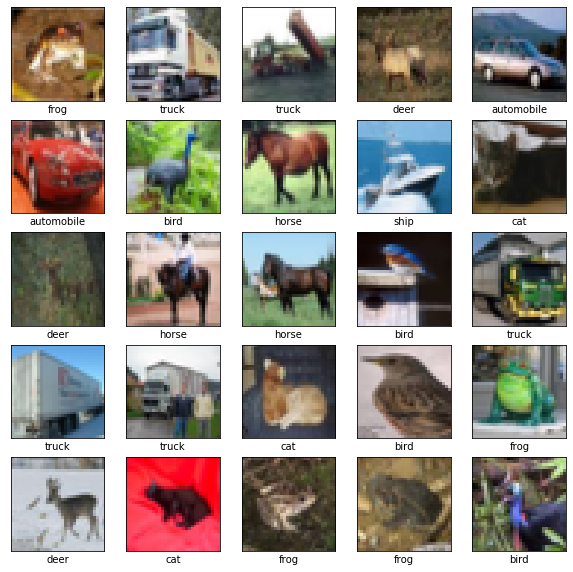

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

## CNN模型

In [5]:
#数据归一化
x_train, x_test = x_train / 255.0, x_test / 255.0

### 搭建简化版AlexNet模型

In [7]:
model_alexnet = tf.keras.models.Sequential([
    Conv2D(filters=18, kernel_size=(3,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2),strides=2),
    
    Conv2D(filters=32, kernel_size=(3,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2),strides=2),
    Dropout(0.2),
    
    Conv2D(filters=56, kernel_size=(3,3),padding='same',activation='relu'),
    Conv2D(filters=56, kernel_size=(3,3),padding='same',activation='relu'),
    Conv2D(filters=32, kernel_size=(3,3),padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2),strides=2),
    Dropout(0.2),

    Flatten(),
    Dense(96, activation="relu"),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

### 训练模型

In [9]:
model_alexnet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

history_alexnet = model_alexnet.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test), validation_freq=1)
model_alexnet.summary()

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 171s 3ms/sample - loss: 1.6633 - sparse_categorical_accuracy: 0.3834 - val_loss: 1.5513 - val_sparse_categorical_accuracy: 0.4471
Epoch 2/10
50000/50000 [==============================] - 172s 3ms/sample - loss: 1.3401 - sparse_categorical_accuracy: 0.5244 - val_loss: 1.1736 - val_sparse_categorical_accuracy: 0.5761
Epoch 3/10
50000/50000 [==============================] - 145s 3ms/sample - loss: 1.2044 - sparse_categorical_accuracy: 0.5800 - val_loss: 1.0814 - val_sparse_categorical_accuracy: 0.6206
Epoch 4/10
50000/50000 [==============================] - 171s 3ms/sample - loss: 1.1195 - sparse_categorical_accuracy: 0.6135 - val_loss: 1.2723 - val_sparse_categorical_accuracy: 0.5490
Epoch 5/10
50000/50000 [==============================] - 175s 3ms/sample - loss: 1.0526 - sparse_categorical_accuracy: 0.6370 - val_loss: 1.1636 - val_sparse_categorical_accuracy: 0.6019
Epoch 6/10

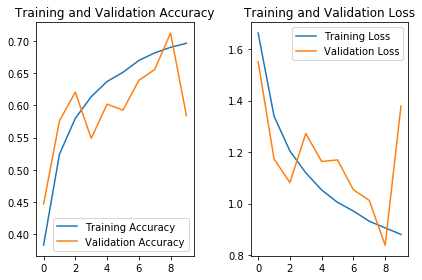

In [33]:
acc = history_alexnet.history['sparse_categorical_accuracy']
val_acc = history_alexnet.history['val_sparse_categorical_accuracy']
loss = history_alexnet.history['loss']
val_loss = history_alexnet.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

### 搭建简化版Inception模型

In [12]:
class ConvBNRelu(Model):
    def __init__(self, filters, kernelsz=3, strides=1, padding='same'):
        super(ConvBNRelu, self).__init__()
        self.model = tf.keras.models.Sequential([
            Conv2D(filters, kernelsz, strides=strides, padding=padding),
            BatchNormalization(),
            Activation('relu')
        ])

    def call(self, x):
        x = self.model(x, training=False) #在training=False时，BN通过整个训练集计算均值、方差去做批归一化，training=True时，通过当前batch的均值、方差去做批归一化。推理时 training=False效果好
        return x

In [13]:
class InceptionBlk(Model):
    def __init__(self, filters, strides=1):
        super(InceptionBlk, self).__init__()
        self.filters = filters
        self.strides = strides
        self.c1 = ConvBNRelu(filters, kernelsz=1, strides=strides)
        self.c2_1 = ConvBNRelu(filters, kernelsz=1, strides=strides)
        self.c2_2 = ConvBNRelu(filters, kernelsz=3, strides=1)
        self.c3_1 = ConvBNRelu(filters, kernelsz=1, strides=strides)
        self.c3_2 = ConvBNRelu(filters, kernelsz=5, strides=1)
        self.p4_1 = MaxPool2D(3, strides=1, padding='same')
        self.c4_2 = ConvBNRelu(filters, kernelsz=1, strides=strides)

    def call(self, x):
        x1 = self.c1(x)
        x2_1 = self.c2_1(x)
        x2_2 = self.c2_2(x2_1)
        x3_1 = self.c3_1(x)
        x3_2 = self.c3_2(x3_1)
        x4_1 = self.p4_1(x)
        x4_2 = self.c4_2(x4_1)
        # concat along axis=channel
        x = tf.concat([x1, x2_2, x3_2, x4_2], axis=3)
        return x

In [16]:
model_inception = tf.keras.models.Sequential([
    ConvBNRelu(16),
    InceptionBlk(16,strides=2),
    InceptionBlk(16, strides=1),
    InceptionBlk(32,strides=2),
    InceptionBlk(32,strides=1),
    GlobalAveragePooling2D(),
    Dense(10,activation='softmax')
])

In [17]:
model_inception.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

history_inception = model_inception.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test), validation_freq=1)
model_inception.summary()

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 389s 8ms/sample - loss: 1.6452 - sparse_categorical_accuracy: 0.3861 - val_loss: 1.3557 - val_sparse_categorical_accuracy: 0.5013
Epoch 2/10
50000/50000 [==============================] - 382s 8ms/sample - loss: 1.2424 - sparse_categorical_accuracy: 0.5478 - val_loss: 1.2328 - val_sparse_categorical_accuracy: 0.5581
Epoch 3/10
50000/50000 [==============================] - 380s 8ms/sample - loss: 1.0651 - sparse_categorical_accuracy: 0.6176 - val_loss: 1.0441 - val_sparse_categorical_accuracy: 0.6235
Epoch 4/10
50000/50000 [==============================] - 378s 8ms/sample - loss: 0.9583 - sparse_categorical_accuracy: 0.6614 - val_loss: 0.9530 - val_sparse_categorical_accuracy: 0.6606
Epoch 5/10
50000/50000 [==============================] - 2037s 41ms/sample - loss: 0.8829 - sparse_categorical_accuracy: 0.6887 - val_loss: 0.9066 - val_sparse_categorical_accuracy: 0.6709
Epoch 6/

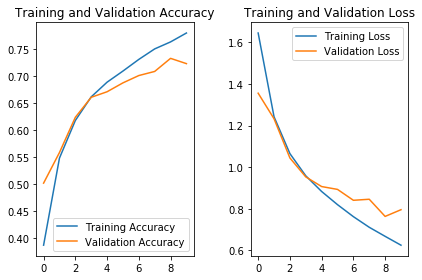

In [34]:
acc = history_inception.history['sparse_categorical_accuracy']
val_acc = history_inception.history['val_sparse_categorical_accuracy']
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

### 迁移学习

In [22]:
from tensorflow.keras.applications.resnet import ResNet50

In [41]:

resnet_base = ResNet50(weights='imagenet', include_top=False, pooling='avg')
resnet_base.trainable=False


In [43]:
model_resnet = tf.keras.models.Sequential([
    resnet_base,
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_resnet.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_11 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
Total params: 23,851,274
Trainable params: 263,562
Non-trainable params: 23,587,712
_________________________________________________________________


In [44]:
model_resnet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

history_resnet = model_resnet.fit(x_train, y_train, batch_size=32, epochs=3, validation_data=(x_test, y_test), validation_freq=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 465s 9ms/sample - loss: 1.8643 - sparse_categorical_accuracy: 0.3463 - val_loss: 4.9330 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/3
50000/50000 [==============================] - 462s 9ms/sample - loss: 1.6708 - sparse_categorical_accuracy: 0.4116 - val_loss: 5.6119 - val_sparse_categorical_accuracy: 0.1000
Epoch 3/3
50000/50000 [==============================] - 477s 10ms/sample - loss: 1.6137 - sparse_categorical_accuracy: 0.4326 - val_loss: 5.5346 - val_sparse_categorical_accuracy: 0.1044
